








#Parkinson's Disease Detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Library Imports

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile as zf
import os
import random
import cv2
import imutils
import pickle

from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
from sklearn.metrics import roc_auc_score, roc_curve

from skimage import feature

from keras.utils import to_categorical
from imutils import build_montages,paths
from google.colab.patches import cv2_imshow

sns.set()

#2. Data Loading

In [ ]:
spiral_train_healthy=os.listdir('/content/drive/MyDrive/Dataset/handpd/Spiral/Train/Healthy/')
spiral_train_park = os.listdir('/content/drive/MyDrive/Dataset/handpd/Spiral/Train/Parkinson/')

fp_spiral_train_healthy = '/content/drive/MyDrive/Dataset/handpd/Spiral/Train/Healthy/'
fp_spiral_train_park = '/content/drive/MyDrive/Dataset/handpd/Spiral/Train/Parkinson/'

spiral_test_healthy = os.listdir('/content/drive/MyDrive/Dataset/handpd/Spiral/Test/Healthy/')
spiral_test_park = os.listdir('/content/drive/MyDrive/Dataset/handpd/Spiral/Test/Parkinson/')

fp_spiral_test_healthy = '/content/drive/MyDrive/Dataset/handpd/Spiral/Test/Healthy/'
fp_spiral_test_park = '/content/drive/MyDrive/Dataset/handpd/Spiral/Test/Parkinson/'

#3. Feature Engineering Techniques
Three feature extraction methods are defined for processing the images:

Histogram of Oriented Gradients (HOG): Captures edge direction and intensity.
Local Binary Patterns (LBP): Used for texture analysis.
Haralick Textures: Extracts statistical texture features.

####Histogram of Oriented Gradients (HOG) technique

In [ ]:
def quantify_image(image):
  features = feature.hog(image,orientations=9,
                pixels_per_cell=(10,10),cells_per_block=(2,2),transform_sqrt=True,block_norm="L1")

  return features

####Local Binary Patterns (LBP) for Texture Analysis:

In [ ]:
from skimage.feature import local_binary_pattern
from skimage import feature

def quantify_image_lbp(image):
    features = local_binary_pattern(image, P=24, R=8, method="uniform")
    (hist, _) = np.histogram(features.ravel(),
                             bins=np.arange(0, 27),
                             range=(0, 26))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist


####Haralick Textures:

In [ ]:
!pip install mahotas

In [ ]:
import mahotas as mt

def quantify_image_haralick(image):
    textures = mt.features.haralick(image)
    ht_mean = textures.mean(axis=0)
    return ht_mean


#4. Image Preprocessing and Feature Extraction For Hog FE Technique

In [ ]:
trainX = []
testX = []
outputs = []
trainY = []
testY = []

for i in spiral_train_healthy:
    image_path = (fp_spiral_train_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image =cv2.threshold(image, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image(image)
    trainX.append(features)
    trainY.append('healthy')

for i in spiral_train_park:

    image_path = (fp_spiral_train_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image(image)
    trainX.append(features)
    trainY.append('parkinson')

for i in spiral_test_healthy:

    image_path = (fp_spiral_test_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image(image)
    testX.append(features)
    testY.append('healthy')

for i in spiral_test_park:


    image_path = (fp_spiral_test_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image(image)
    testX.append(features)
    testY.append('parkinson')


In [ ]:
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)


In [ ]:
trainX


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
testX

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
trainY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 

In [ ]:
testY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson'],
      dtype='<U9')

In [ ]:
le = LabelEncoder()

In [ ]:
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

In [ ]:
trainY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
testY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#5. Machine Learning Models

Several classification models are trained and evaluated:

Random Forest Classifier: An ensemble method for classification.

Decision Tree: A tree-based model for classification.

Support Vector Machine (SVM): A powerful classifier, especially effective in high-dimensional spaces.

Logistic Regression: A linear model for binary classification.

Naive Bayes: A probabilistic classifier based on Bayes' theorem.

Each model is trained on the extracted features and evaluated on the test set. Performance metrics like confusion matrix, sensitivity, specificity, and accuracy are calculated. Also, ROC curves and calibration curves are plotted to evaluate model performance.

#Random Forests

In [ ]:
model = RandomForestClassifier(n_estimators=100)

In [ ]:
model.fit(trainX,trainY)

RandomForestClassifier()

In [ ]:
preds = model.predict(testX)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds)
cnf

array([[35,  0],
       [ 7, 24]])

In [ ]:
sensitivity= 35/(35+9)
sensitivity

0.7954545454545454

In [ ]:
specificity= 22/(22+0)
specificity

1.0

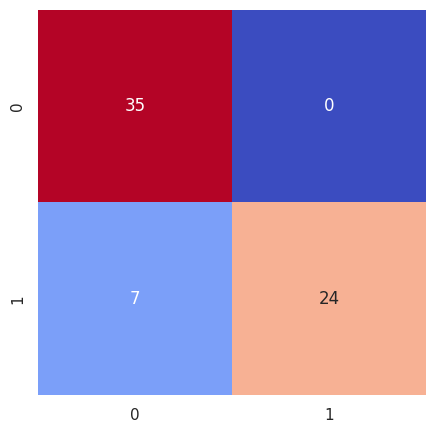

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc = metrics.accuracy_score(testY,preds)
acc

0.8939393939393939

In [ ]:
indexes = np.random.randint(0,30,25)
indexes

array([25, 23, 22,  1, 23,  5,  5,  3, 11, 23,  8, 15, 23, 27, 22, 12,  8,
       15,  8, 22,  3, 23, 26, 17,  8])

In [ ]:
labels = []

for i in indexes:
  pred = le.inverse_transform(preds)[i]
  labels.append(pred)

In [ ]:
labels

['healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy']

In [ ]:
results = []

for i in range(25):
  image = outputs[i]

  if labels[i] == 'healthy':
    color = (0,255,0)
  else:
    color = (0,0,255)

  text = str(labels[i])

  image = cv2.resize(image,(128,128))
  cv2.putText(image,text,(3,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

  results.append(image)


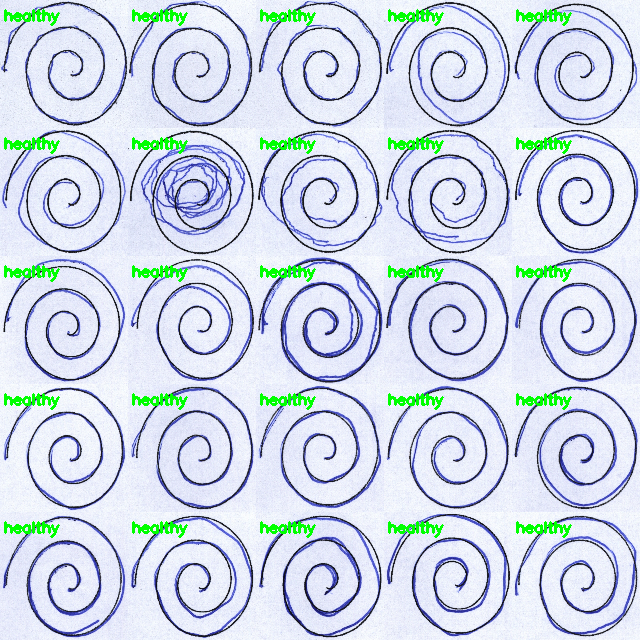

-1

In [ ]:
montage = build_montages(results,(128,128),(5,5))[0]

cv2_imshow(montage)
cv2.waitKey(0)

#Decision Trees

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=7)
clf.fit(trainX,trainY)

DecisionTreeClassifier(max_depth=7)

In [ ]:
preds_dt = clf.predict(testX)
preds_dt

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds_dt)
cnf

array([[31,  4],
       [13, 18]])

In [ ]:
sensitivity=29/(29+10)
sensitivity

0.7435897435897436

In [ ]:
specificity=21/(21+6)
specificity

0.7777777777777778

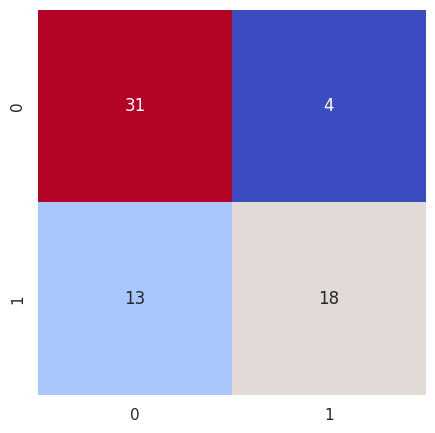

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_dt = metrics.accuracy_score(testY,preds_dt)
acc_dt

0.7424242424242424

#Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svm_mod = SVC(probability=True)
svm_mod.fit(trainX,trainY)

SVC(probability=True)

In [ ]:
pred_svc = svm_mod.predict(testX)
pred_svc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,pred_svc)
cnf

array([[33,  2],
       [ 4, 27]])

In [ ]:
sensitivity= 33/(33+4)
sensitivity

0.8918918918918919

In [ ]:
specificity=27/(27+2)
specificity

0.9310344827586207

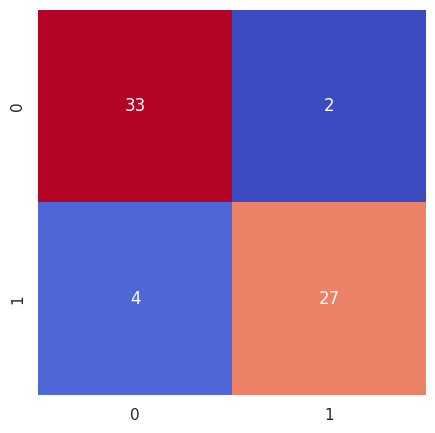

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_svc = metrics.accuracy_score(testY,pred_svc)
acc_svc

0.9090909090909091

In [ ]:
with open('/content/drive/MyDrive/spiral_svm_model_pkl.pkl', 'wb') as files:
    pickle.dump(svm_mod, files)

# Logistic Regression

In [ ]:
lg_mod = LogisticRegression()
lg_mod.fit(trainX, trainY)

LogisticRegression()

In [ ]:
pred_lg = lg_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_lg)
cnf

array([[34,  1],
       [ 6, 25]])

In [ ]:
sensitivity=34/(34+6)
sensitivity

0.85

In [ ]:
specificity=25/(25+1)
specificity

0.9615384615384616

In [ ]:
acc_lg = metrics.accuracy_score(testY,pred_lg)
acc_lg

0.8939393939393939

# Naive Bayes

In [ ]:
gnb_mod = GaussianNB()
gnb_mod.fit(trainX, trainY)

GaussianNB()

In [ ]:
pred_nb = gnb_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_nb)
cnf

array([[29,  6],
       [15, 16]])

In [ ]:
sensitivity=29/(29+15)
sensitivity

0.6590909090909091

In [ ]:
specificity=16/(16+6)
specificity

0.7272727272727273

In [ ]:
acc_nb = metrics.accuracy_score(testY,pred_nb)
acc_nb

0.6818181818181818

No Skill AUC:  0.5
DecisionTree AUC:  0.7331797235023041
Support Vector Machine AUC:  0.9548387096774192
Logistic Regression AUC:  0.9769585253456221
Gaussian Naive Bayes AUC:  0.6723502304147465


Text(0.5, 1.0, 'ROC curve')

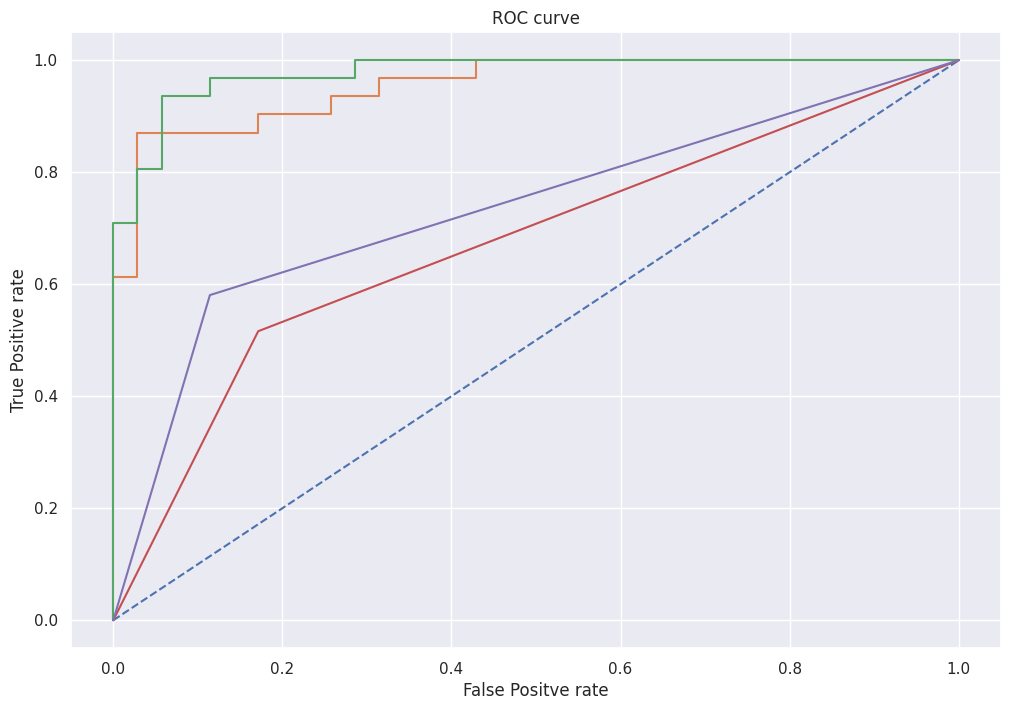

In [ ]:
no_skill_prob = [0 for _ in range(len(testY))]
no_skill_auc = roc_auc_score(testY, no_skill_prob)
print("No Skill AUC: ", no_skill_auc)
ns_fpr, ns_tpr, _ = roc_curve(testY, no_skill_prob)

dt_prob = clf.predict_proba(testX)[:,-1]
dt_auc = roc_auc_score(testY,dt_prob)
print("DecisionTree AUC: ", dt_auc)
dt_fpr, dt_tpr, _ = roc_curve(testY, dt_prob)

svm_prob = svm_mod.predict_proba(testX)[:,-1]
svm_auc = roc_auc_score(testY,svm_prob)
print("Support Vector Machine AUC: ", svm_auc)
svm_fpr, svm_tpr, _ = roc_curve(testY, svm_prob)

lg_prob = lg_mod.predict_proba(testX)[:,-1]
lg_auc = roc_auc_score(testY, lg_prob)
print("Logistic Regression AUC: ",lg_auc)
lg_fpr, lg_tpr, _ = roc_curve(testY, lg_prob)

nb_prob = gnb_mod.predict_proba(testX)[:,-1]
nb_auc = roc_auc_score(testY, nb_prob)
print("Gaussian Naive Bayes AUC: ", nb_auc)
nb_fpr, nb_tpr, _ = roc_curve(testY, nb_prob)




fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
ax.plot(dt_fpr, dt_tpr, linestyle='-', label= 'Decision Tree')

plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')


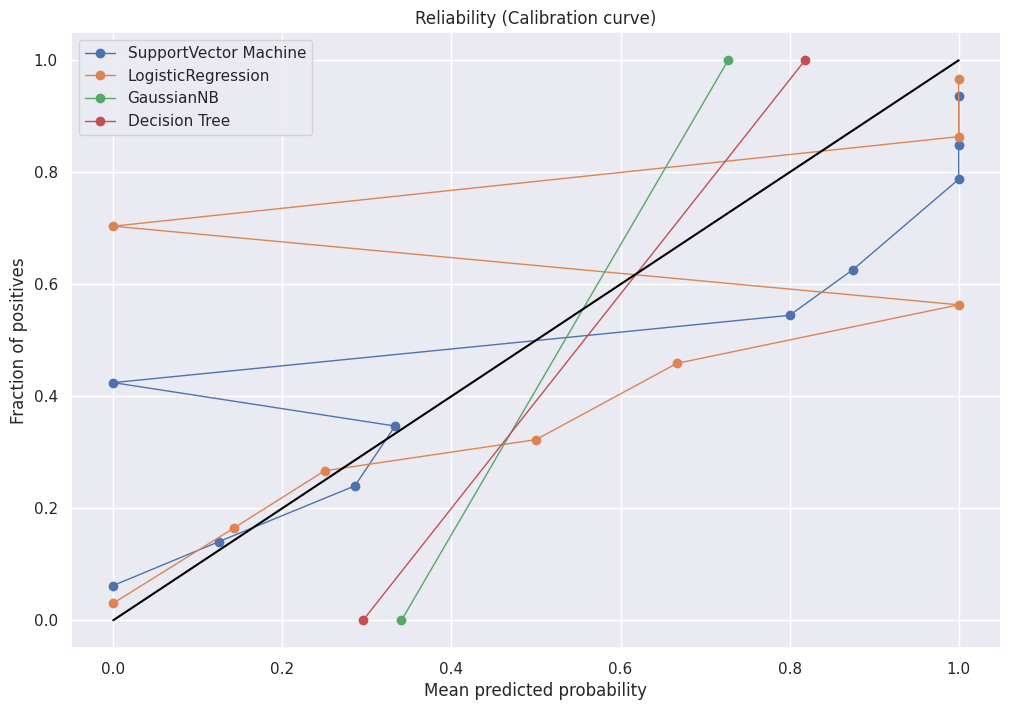

In [ ]:
sv_x, sv_y = calibration_curve(testY, svm_prob, n_bins=10)
lg_x, lg_y = calibration_curve(testY, lg_prob, n_bins=10)
nb_x, nb_y = calibration_curve(testY, nb_prob, n_bins=10)
dt_x, dt_y = calibration_curve(testY,dt_prob,n_bins=10)




fig, ax = plt.subplots(figsize=(12,8))

ax.plot(sv_x, sv_y, marker= 'o', linewidth= '1', label= 'SupportVector Machine')
ax.plot(lg_x, lg_y, marker= 'o', linewidth= '1', label= 'LogisticRegression')
ax.plot(nb_x, nb_y, marker= 'o', linewidth= '1', label= 'GaussianNB')
ax.plot(dt_x, dt_y, marker= 'o', linewidth= '1', label= 'Decision Tree')




line = mlines.Line2D([0,1],[0,1], color='black')
ax.add_line(line)
ax.legend()
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability (Calibration curve)')
plt.show()

In [ ]:
spiral_model = {
    'Random Forest': model,
    'Support Vector Machine': svm_mod,
    'Decision tree':clf,
    'Gaussian Naive Bayes': gnb_mod,
    'Logistic Regression': lg_mod

}

columns = [
    'accuracy'
]

spiral_table = {}


for model in spiral_model.keys():

    spiral_pred = spiral_model[model].predict(testX)
    accuracy = spiral_model[model].score(testX,testY)
    spiral_table[model] = [accuracy]

In [ ]:
spiral_results = pd.DataFrame.from_dict(spiral_table, orient='index')
spiral_results.columns = columns
spiral_results

accuracy
Random Forest           0.893939
Support Vector Machine  0.909091
Decision tree           0.742424
Gaussian Naive Bayes    0.681818
Logistic Regression     0.893939

#Local Binary Patterns


In [ ]:
trainX = []
testX = []
outputs = []
trainY = []
testY = []

for i in spiral_train_healthy:
    image_path = (fp_spiral_train_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image =cv2.threshold(image, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_lbp(image)
    trainX.append(features)
    trainY.append('healthy')
    # ... rest of your code ...



for i in spiral_train_park:

    image_path = (fp_spiral_train_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_lbp(image)
    trainX.append(features)
    trainY.append('parkinson')

for i in spiral_test_healthy:

    image_path = (fp_spiral_test_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_lbp(image)
    testX.append(features)
    testY.append('healthy')

for i in spiral_test_park:


    image_path = (fp_spiral_test_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_lbp(image)
    testX.append(features)
    testY.append('parkinson')


In [ ]:
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)


In [ ]:
trainX


array([[7.50000e-05, 4.22500e-03, 2.55000e-03, ..., 0.00000e+00,
        9.00950e-01, 9.18750e-02],
       [3.50000e-04, 3.77500e-03, 3.07500e-03, ..., 0.00000e+00,
        8.89375e-01, 1.02850e-01],
       [3.75000e-04, 4.67500e-03, 2.80000e-03, ..., 0.00000e+00,
        8.96700e-01, 9.48000e-02],
       ...,
       [1.00000e-04, 3.50000e-03, 2.15000e-03, ..., 0.00000e+00,
        9.01925e-01, 9.22250e-02],
       [1.75000e-04, 4.50000e-03, 2.85000e-03, ..., 0.00000e+00,
        9.05725e-01, 8.61250e-02],
       [1.75000e-04, 4.50000e-03, 2.85000e-03, ..., 0.00000e+00,
        9.05725e-01, 8.61250e-02]])

In [ ]:
testX

array([[2.25000e-04, 5.02500e-03, 2.87500e-03, ..., 0.00000e+00,
        9.01250e-01, 9.00750e-02],
       [4.75000e-04, 5.62500e-03, 2.12500e-03, ..., 0.00000e+00,
        8.84225e-01, 1.07025e-01],
       [3.05000e-03, 1.27500e-02, 1.07500e-03, ..., 0.00000e+00,
        8.88525e-01, 9.41250e-02],
       ...,
       [7.50000e-05, 2.62500e-03, 1.60000e-03, ..., 0.00000e+00,
        8.99050e-01, 9.65250e-02],
       [1.00000e-04, 3.50000e-03, 2.15000e-03, ..., 0.00000e+00,
        9.01925e-01, 9.22250e-02],
       [1.56250e-02, 3.56250e-02, 8.50000e-04, ..., 0.00000e+00,
        9.06250e-01, 4.09750e-02]])

In [ ]:
trainY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 

In [ ]:
testY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson'],
      dtype='<U9')

In [ ]:
le = LabelEncoder()

In [ ]:
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

In [ ]:
trainY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
testY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#Random Forests

In [ ]:
model = RandomForestClassifier(n_estimators=100)

In [ ]:
model.fit(trainX,trainY)

RandomForestClassifier()

In [ ]:
preds = model.predict(testX)
preds

array([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds)
cnf

array([[27,  8],
       [ 8, 23]])

In [ ]:
sensitivity= 35/(35+9)
sensitivity

0.7954545454545454

In [ ]:
specificity= 22/(22+0)
specificity

1.0

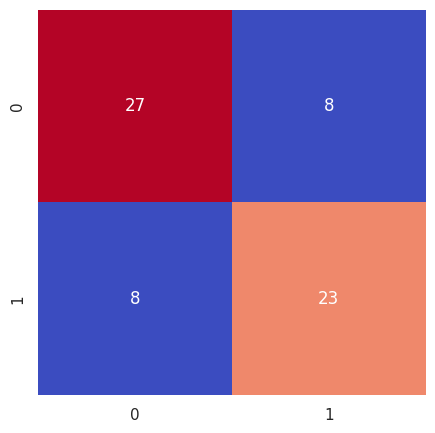

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc = metrics.accuracy_score(testY,preds)
acc

0.7575757575757576

In [ ]:
indexes = np.random.randint(0,30,25)
indexes

array([11,  2, 18, 24, 11,  7, 17, 28, 23, 16,  1, 21, 12, 27, 18, 19, 29,
        2,  7,  5, 11,  1, 15, 24, 11])

In [ ]:
labels = []

for i in indexes:
  pred = le.inverse_transform(preds)[i]
  labels.append(pred)

In [ ]:
labels

['healthy',
 'parkinson',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'parkinson',
 'healthy',
 'healthy',
 'healthy',
 'parkinson',
 'parkinson',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'parkinson',
 'healthy',
 'parkinson',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy']

In [ ]:
results = []

for i in range(25):
  image = outputs[i]

  if labels[i] == 'healthy':
    color = (0,255,0)
  else:
    color = (0,0,255)

  text = str(labels[i])

  image = cv2.resize(image,(128,128))
  cv2.putText(image,text,(3,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

  results.append(image)


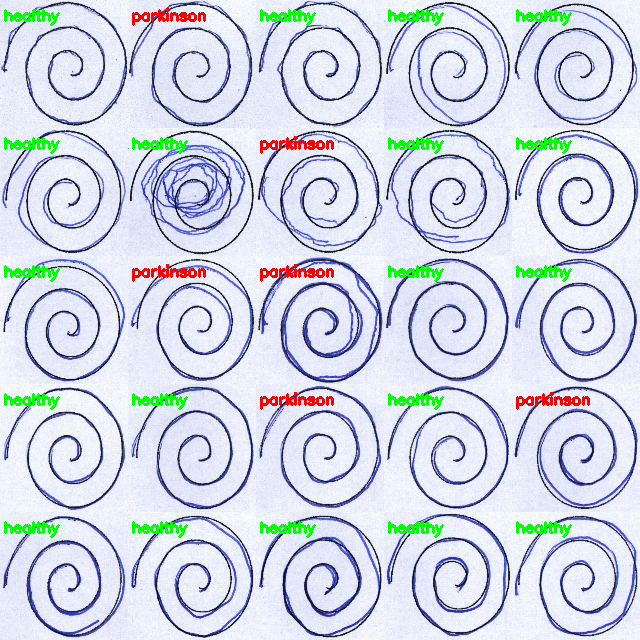

-1

In [ ]:
montage = build_montages(results,(128,128),(5,5))[0]

cv2_imshow(montage)
cv2.waitKey(0)

#Decision Trees

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=7)
clf.fit(trainX,trainY)

DecisionTreeClassifier(max_depth=7)

In [ ]:
preds_dt = clf.predict(testX)
preds_dt

array([1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds_dt)
cnf

array([[24, 11],
       [ 3, 28]])

In [ ]:
sensitivity=29/(29+10)
sensitivity

0.7435897435897436

In [ ]:
specificity=21/(21+6)
specificity

0.7777777777777778

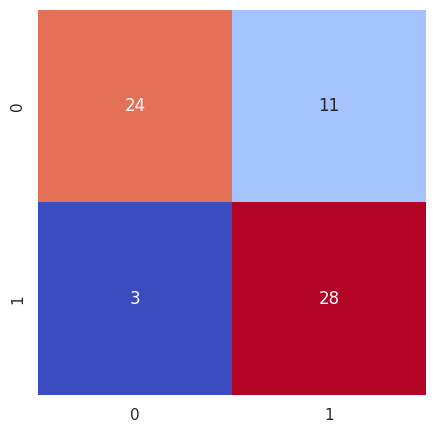

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_dt = metrics.accuracy_score(testY,preds_dt)
acc_dt

0.7878787878787878

#Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svm_mod = SVC(probability=True)
svm_mod.fit(trainX,trainY)

SVC(probability=True)

In [ ]:
pred_svc = svm_mod.predict(testX)
pred_svc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cnf = confusion_matrix(testY,pred_svc)
cnf

array([[35,  0],
       [31,  0]])

In [ ]:
sensitivity= 33/(33+4)
sensitivity

0.8918918918918919

In [ ]:
specificity=27/(27+2)
specificity

0.9310344827586207

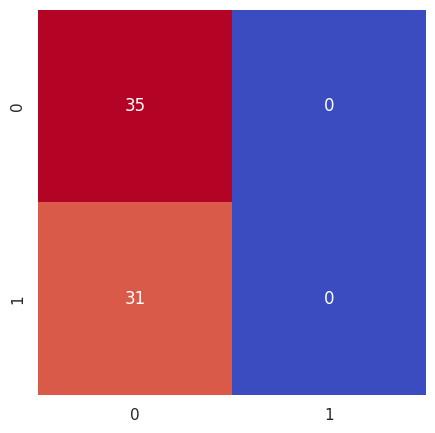

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_svc = metrics.accuracy_score(testY,pred_svc)
acc_svc

0.5303030303030303

In [ ]:
with open('/content/drive/MyDrive/spiral_svm_model_pkl.pkl', 'wb') as files:
    pickle.dump(svm_mod, files)

# Logistic Regression

In [ ]:
lg_mod = LogisticRegression()
lg_mod.fit(trainX, trainY)

LogisticRegression()

In [ ]:
pred_lg = lg_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_lg)
cnf

array([[35,  0],
       [31,  0]])

In [ ]:
sensitivity=34/(34+6)
sensitivity

0.85

In [ ]:
specificity=25/(25+1)
specificity

0.9615384615384616

In [ ]:
acc_lg = metrics.accuracy_score(testY,pred_lg)
acc_lg

0.5303030303030303

# Naive Bayes

In [ ]:
gnb_mod = GaussianNB()
gnb_mod.fit(trainX, trainY)

GaussianNB()

In [ ]:
pred_nb = gnb_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_nb)
cnf

array([[35,  0],
       [28,  3]])

In [ ]:
sensitivity=29/(29+15)
sensitivity

0.6590909090909091

In [ ]:
specificity=16/(16+6)
specificity

0.7272727272727273

In [ ]:
acc_nb = metrics.accuracy_score(testY,pred_nb)
acc_nb

0.5757575757575758

No Skill AUC:  0.5
DecisionTree AUC:  0.8055299539170507
Support Vector Machine AUC:  0.3050691244239631
Logistic Regression AUC:  0.6414746543778802
Gaussian Naive Bayes AUC:  0.8147465437788017


Text(0.5, 1.0, 'ROC curve')

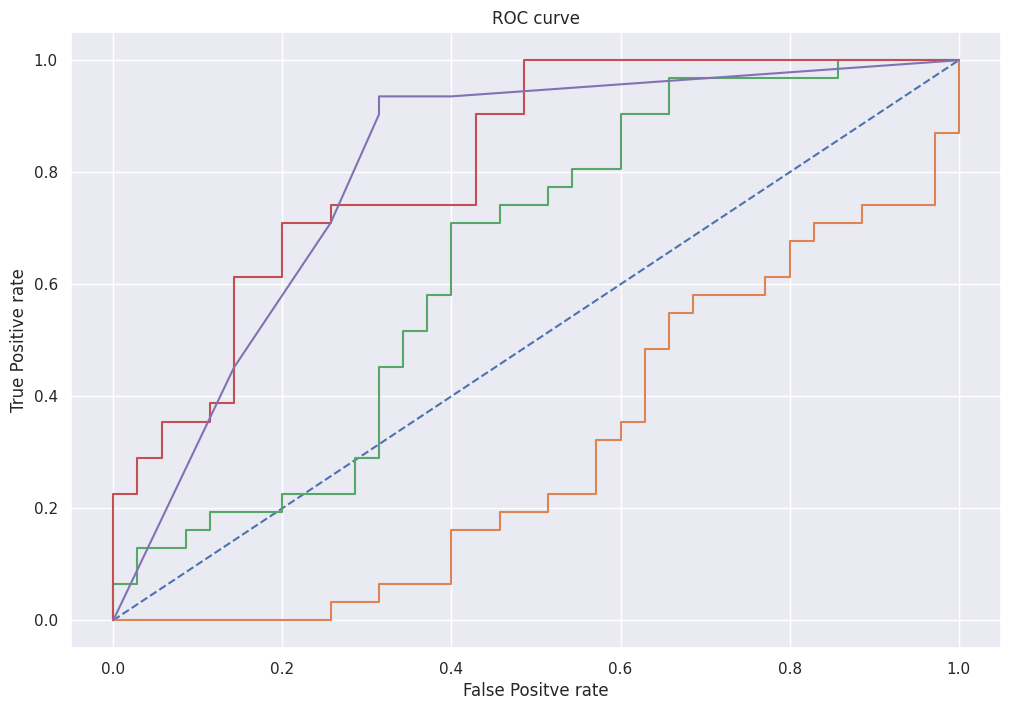

In [ ]:
no_skill_prob = [0 for _ in range(len(testY))]
no_skill_auc = roc_auc_score(testY, no_skill_prob)
print("No Skill AUC: ", no_skill_auc)
ns_fpr, ns_tpr, _ = roc_curve(testY, no_skill_prob)

dt_prob = clf.predict_proba(testX)[:,-1]
dt_auc = roc_auc_score(testY,dt_prob)
print("DecisionTree AUC: ", dt_auc)
dt_fpr, dt_tpr, _ = roc_curve(testY, dt_prob)

svm_prob = svm_mod.predict_proba(testX)[:,-1]
svm_auc = roc_auc_score(testY,svm_prob)
print("Support Vector Machine AUC: ", svm_auc)
svm_fpr, svm_tpr, _ = roc_curve(testY, svm_prob)

lg_prob = lg_mod.predict_proba(testX)[:,-1]
lg_auc = roc_auc_score(testY, lg_prob)
print("Logistic Regression AUC: ",lg_auc)
lg_fpr, lg_tpr, _ = roc_curve(testY, lg_prob)

nb_prob = gnb_mod.predict_proba(testX)[:,-1]
nb_auc = roc_auc_score(testY, nb_prob)
print("Gaussian Naive Bayes AUC: ", nb_auc)
nb_fpr, nb_tpr, _ = roc_curve(testY, nb_prob)


fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
ax.plot(dt_fpr, dt_tpr, linestyle='-', label= 'Decision Tree')

plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')


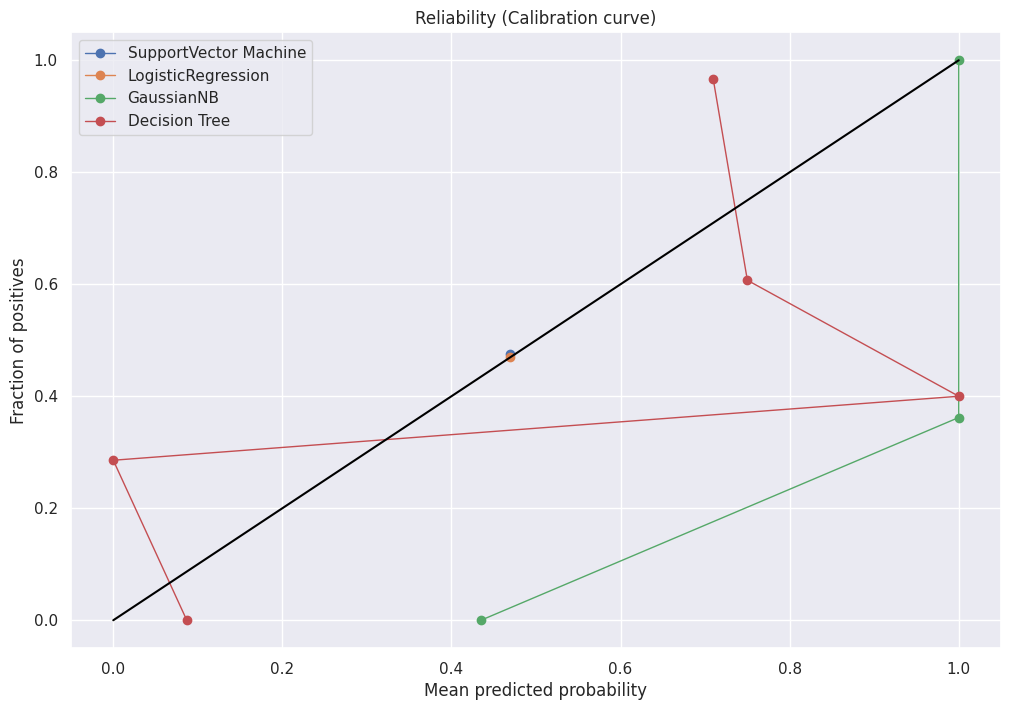

In [ ]:
sv_x, sv_y = calibration_curve(testY, svm_prob, n_bins=10)
lg_x, lg_y = calibration_curve(testY, lg_prob, n_bins=10)
nb_x, nb_y = calibration_curve(testY, nb_prob, n_bins=10)
dt_x, dt_y = calibration_curve(testY,dt_prob,n_bins=10)




fig, ax = plt.subplots(figsize=(12,8))

ax.plot(sv_x, sv_y, marker= 'o', linewidth= '1', label= 'SupportVector Machine')
ax.plot(lg_x, lg_y, marker= 'o', linewidth= '1', label= 'LogisticRegression')
ax.plot(nb_x, nb_y, marker= 'o', linewidth= '1', label= 'GaussianNB')
ax.plot(dt_x, dt_y, marker= 'o', linewidth= '1', label= 'Decision Tree')




line = mlines.Line2D([0,1],[0,1], color='black')
ax.add_line(line)
ax.legend()
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability (Calibration curve)')
plt.show()

In [ ]:
spiral_model = {
    'Random Forest': model,
    'Support Vector Machine': svm_mod,
    'Decision tree':clf,
    'Gaussian Naive Bayes': gnb_mod,
    'Logistic Regression': lg_mod

}

columns = [
    'accuracy'
]

spiral_table = {}


for model in spiral_model.keys():

    spiral_pred = spiral_model[model].predict(testX)
    accuracy = spiral_model[model].score(testX,testY)
    spiral_table[model] = [accuracy]

In [ ]:
spiral_results = pd.DataFrame.from_dict(spiral_table, orient='index')
spiral_results.columns = columns
spiral_results

accuracy
Random Forest           0.757576
Support Vector Machine  0.530303
Decision tree           0.787879
Gaussian Naive Bayes    0.575758
Logistic Regression     0.530303

In [ ]:
#

####Haralick Textures:

In [ ]:
!pip install mahotas

In [ ]:
import mahotas as mt

def quantify_image_haralick(image):
    textures = mt.features.haralick(image)
    ht_mean = textures.mean(axis=0)
    return ht_mean


In [ ]:
trainX = []
testX = []
outputs = []
trainY = []
testY = []

for i in spiral_train_healthy:
    image_path = (fp_spiral_train_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image =cv2.threshold(image, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_haralick(image)
    trainX.append(features)
    trainY.append('healthy')
    # ... rest of your code ...



for i in spiral_train_park:

    image_path = (fp_spiral_train_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_haralick(image)
    trainX.append(features)
    trainY.append('parkinson')

for i in spiral_test_healthy:

    image_path = (fp_spiral_test_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_haralick(image)
    testX.append(features)
    testY.append('healthy')

for i in spiral_test_park:


    image_path = (fp_spiral_test_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_haralick(image)
    testX.append(features)
    testY.append('parkinson')


In [ ]:
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)


In [ ]:
trainX


array([[ 7.74926518e-01,  3.10423317e+03,  7.34399264e-01, ...,
         2.75710697e-01, -4.93883567e-01,  6.07174457e-01],
       [ 7.53550137e-01,  3.31967231e+03,  7.42343849e-01, ...,
         2.89807051e-01, -4.99571966e-01,  6.27775767e-01],
       [ 7.65847882e-01,  3.26719796e+03,  7.30670090e-01, ...,
         2.86486580e-01, -4.86983458e-01,  6.10654912e-01],
       ...,
       [ 7.76841928e-01,  3.07968111e+03,  7.34172639e-01, ...,
         2.74078470e-01, -4.94025059e-01,  6.05639279e-01],
       [ 7.80070177e-01,  3.29268597e+03,  7.05581570e-01, ...,
         2.88012550e-01, -4.59390109e-01,  5.81716308e-01],
       [ 7.80070177e-01,  3.29268597e+03,  7.05581570e-01, ...,
         2.88012550e-01, -4.59390109e-01,  5.81716308e-01]])

In [ ]:
testX

array([[ 7.73181203e-01,  3.26563395e+03,  7.19835228e-01,
         5.82599019e+03,  9.49779566e-01,  5.07427527e+01,
         2.00383268e+04,  6.62444547e-01,  7.12665753e-01,
         3.51890933e-03,  2.86236819e-01, -4.75333303e-01,
         5.97326793e-01],
       [ 7.36278143e-01,  4.00137900e+03,  7.01509125e-01,
         6.70030806e+03,  9.38464937e-01,  5.94910602e+01,
         2.27998532e+04,  7.46280541e-01,  8.07816550e-01,
         3.44069594e-03,  3.32100473e-01, -4.45563342e-01,
         6.06721787e-01],
       [ 7.40853974e-01,  4.15875687e+03,  6.79380807e-01,
         6.48309377e+03,  9.36044707e-01,  5.72815024e+01,
         2.17736182e+04,  7.36652691e-01,  8.00608967e-01,
         3.42424972e-03,  3.41461846e-01, -4.20573877e-01,
         5.86735735e-01],
       [ 7.44233765e-01,  3.21645183e+03,  7.63202324e-01,
         6.78926029e+03,  9.50535911e-01,  6.04031451e+01,
         2.39405893e+04,  7.24443642e-01,  7.73908491e-01,
         3.52422376e-03,  2.83020635e

In [ ]:
trainY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 

In [ ]:
testY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson'],
      dtype='<U9')

In [ ]:
le = LabelEncoder()

In [ ]:
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

In [ ]:
trainY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
testY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#Random Forests

In [ ]:
model = RandomForestClassifier(n_estimators=100)

In [ ]:
model.fit(trainX,trainY)

RandomForestClassifier()

In [ ]:
preds = model.predict(testX)
preds

array([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds)
cnf

array([[24, 11],
       [ 8, 23]])

In [ ]:
sensitivity= 35/(35+9)
sensitivity

0.7954545454545454

In [ ]:
specificity= 22/(22+0)
specificity

1.0

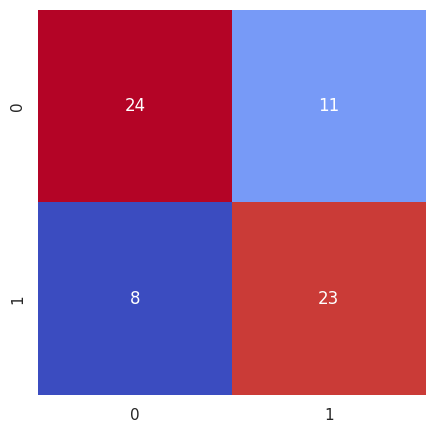

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc = metrics.accuracy_score(testY,preds)
acc

0.7121212121212122

In [ ]:
indexes = np.random.randint(0,30,25)
indexes

array([21, 28,  9, 12, 27,  5, 22,  8, 16, 27, 15,  3,  7,  7, 20,  8, 16,
       19, 14, 27, 28, 24, 10,  9, 17])

In [ ]:
labels = []

for i in indexes:
  pred = le.inverse_transform(preds)[i]
  labels.append(pred)

In [ ]:
labels

['parkinson',
 'parkinson',
 'healthy',
 'parkinson',
 'healthy',
 'healthy',
 'healthy',
 'parkinson',
 'parkinson',
 'healthy',
 'healthy',
 'parkinson',
 'parkinson',
 'parkinson',
 'healthy',
 'parkinson',
 'parkinson',
 'healthy',
 'healthy',
 'healthy',
 'parkinson',
 'parkinson',
 'healthy',
 'healthy',
 'healthy']

In [ ]:
results = []

for i in range(25):
  image = outputs[i]

  if labels[i] == 'healthy':
    color = (0,255,0)
  else:
    color = (0,0,255)

  text = str(labels[i])

  image = cv2.resize(image,(128,128))
  cv2.putText(image,text,(3,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

  results.append(image)


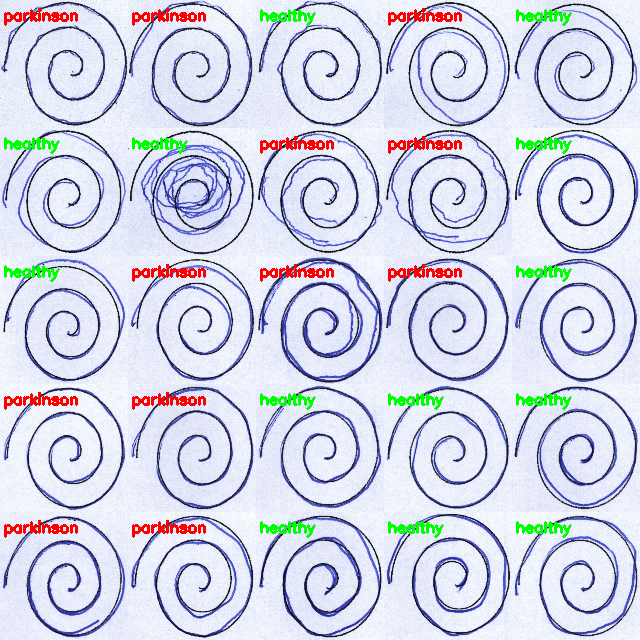

-1

In [ ]:
montage = build_montages(results,(128,128),(5,5))[0]

cv2_imshow(montage)
cv2.waitKey(0)

#Decision Trees

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=7)
clf.fit(trainX,trainY)

DecisionTreeClassifier(max_depth=7)

In [ ]:
preds_dt = clf.predict(testX)
preds_dt

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds_dt)
cnf

array([[27,  8],
       [11, 20]])

In [ ]:
sensitivity=29/(29+10)
sensitivity

0.7435897435897436

In [ ]:
specificity=21/(21+6)
specificity

0.7777777777777778

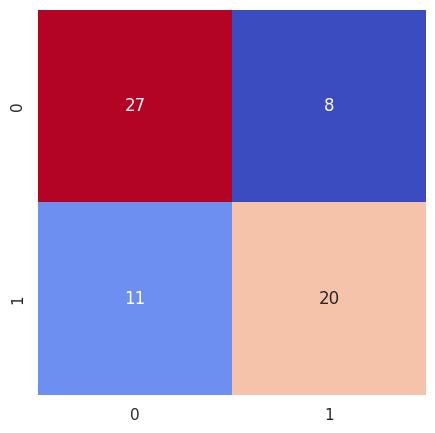

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_dt = metrics.accuracy_score(testY,preds_dt)
acc_dt

0.7121212121212122

#Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svm_mod = SVC(probability=True)
svm_mod.fit(trainX,trainY)

SVC(probability=True)

In [ ]:
pred_svc = svm_mod.predict(testX)
pred_svc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cnf = confusion_matrix(testY,pred_svc)
cnf

array([[35,  0],
       [29,  2]])

In [ ]:
sensitivity= 33/(33+4)
sensitivity

0.8918918918918919

In [ ]:
specificity=27/(27+2)
specificity

0.9310344827586207

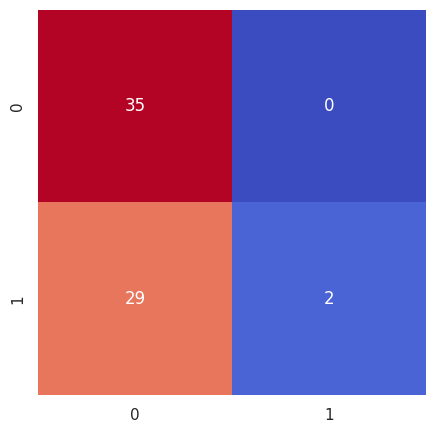

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_svc = metrics.accuracy_score(testY,pred_svc)
acc_svc

0.5606060606060606

In [ ]:
with open('/content/drive/MyDrive/spiral_svm_model_pkl.pkl', 'wb') as files:
    pickle.dump(svm_mod, files)

# Logistic Regression

In [ ]:
lg_mod = LogisticRegression()
lg_mod.fit(trainX, trainY)

LogisticRegression()

In [ ]:
pred_lg = lg_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_lg)
cnf

array([[25, 10],
       [17, 14]])

In [ ]:
sensitivity=34/(34+6)
sensitivity

0.85

In [ ]:
specificity=25/(25+1)
specificity

0.9615384615384616

In [ ]:
acc_lg = metrics.accuracy_score(testY,pred_lg)
acc_lg

0.5909090909090909

# Naive Bayes

In [ ]:
gnb_mod = GaussianNB()
gnb_mod.fit(trainX, trainY)

GaussianNB()

In [ ]:
pred_nb = gnb_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_nb)
cnf

array([[23, 12],
       [14, 17]])

In [ ]:
sensitivity=29/(29+15)
sensitivity

0.6590909090909091

In [ ]:
specificity=16/(16+6)
specificity

0.7272727272727273

In [ ]:
acc_nb = metrics.accuracy_score(testY,pred_nb)
acc_nb

0.6060606060606061

No Skill AUC:  0.5
DecisionTree AUC:  0.7493087557603687
Support Vector Machine AUC:  0.34285714285714286
Logistic Regression AUC:  0.56036866359447
Gaussian Naive Bayes AUC:  0.7354838709677419


Text(0.5, 1.0, 'ROC curve')

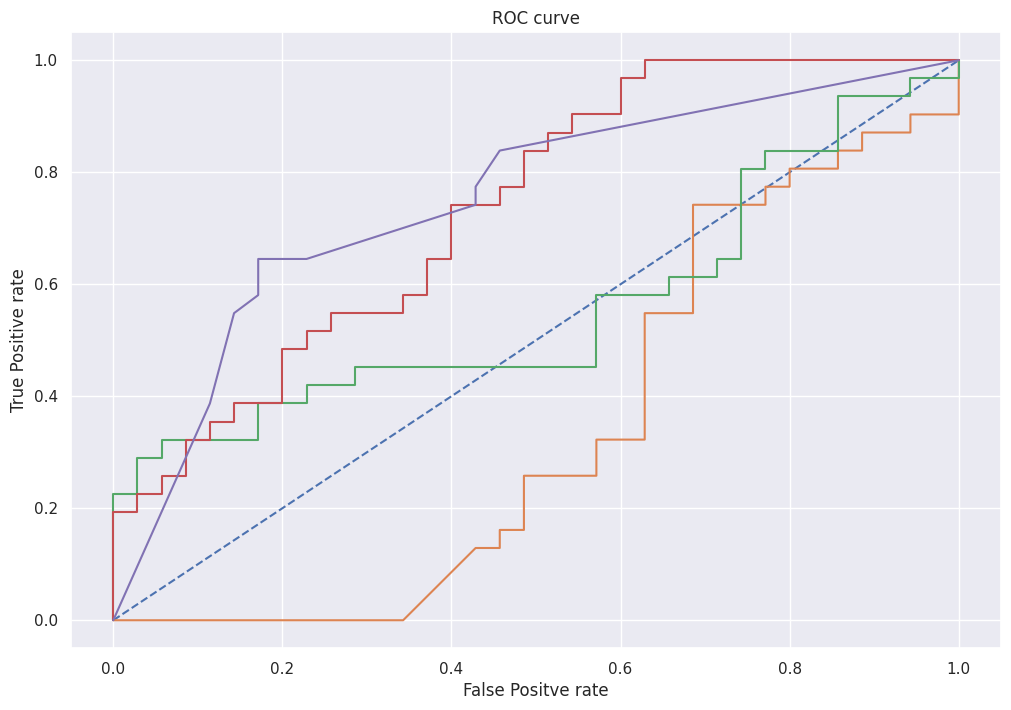

In [ ]:
no_skill_prob = [0 for _ in range(len(testY))]
no_skill_auc = roc_auc_score(testY, no_skill_prob)
print("No Skill AUC: ", no_skill_auc)
ns_fpr, ns_tpr, _ = roc_curve(testY, no_skill_prob)

dt_prob = clf.predict_proba(testX)[:,-1]
dt_auc = roc_auc_score(testY,dt_prob)
print("DecisionTree AUC: ", dt_auc)
dt_fpr, dt_tpr, _ = roc_curve(testY, dt_prob)

svm_prob = svm_mod.predict_proba(testX)[:,-1]
svm_auc = roc_auc_score(testY,svm_prob)
print("Support Vector Machine AUC: ", svm_auc)
svm_fpr, svm_tpr, _ = roc_curve(testY, svm_prob)

lg_prob = lg_mod.predict_proba(testX)[:,-1]
lg_auc = roc_auc_score(testY, lg_prob)
print("Logistic Regression AUC: ",lg_auc)
lg_fpr, lg_tpr, _ = roc_curve(testY, lg_prob)

nb_prob = gnb_mod.predict_proba(testX)[:,-1]
nb_auc = roc_auc_score(testY, nb_prob)
print("Gaussian Naive Bayes AUC: ", nb_auc)
nb_fpr, nb_tpr, _ = roc_curve(testY, nb_prob)


fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
ax.plot(dt_fpr, dt_tpr, linestyle='-', label= 'Decision Tree')

plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')


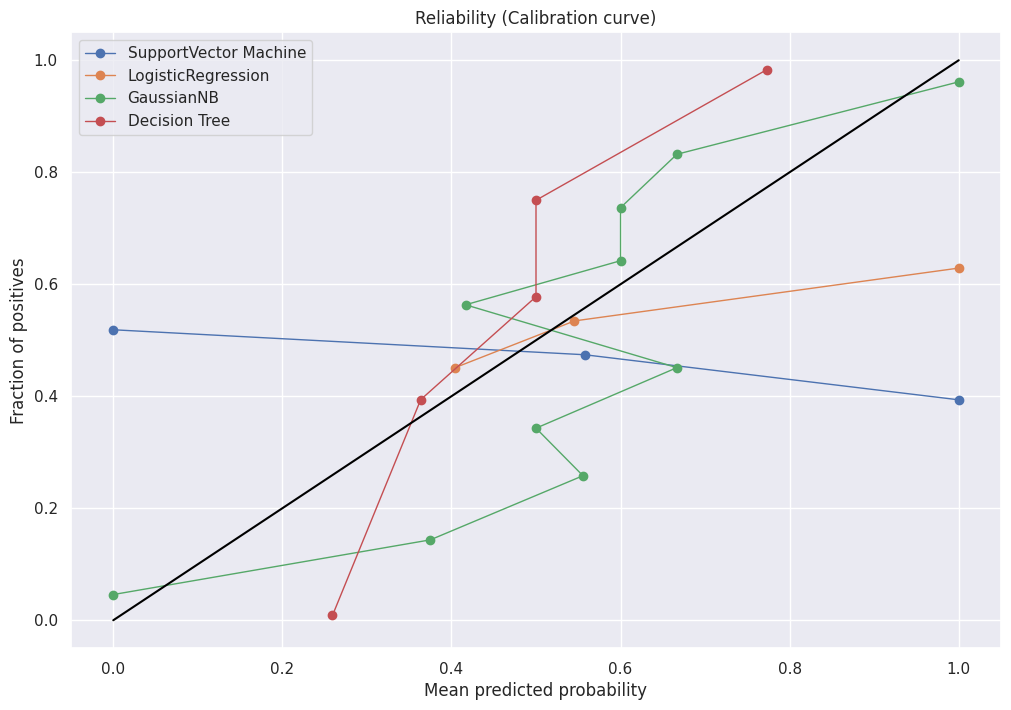

In [ ]:
sv_x, sv_y = calibration_curve(testY, svm_prob, n_bins=10)
lg_x, lg_y = calibration_curve(testY, lg_prob, n_bins=10)
nb_x, nb_y = calibration_curve(testY, nb_prob, n_bins=10)
dt_x, dt_y = calibration_curve(testY,dt_prob,n_bins=10)




fig, ax = plt.subplots(figsize=(12,8))

ax.plot(sv_x, sv_y, marker= 'o', linewidth= '1', label= 'SupportVector Machine')
ax.plot(lg_x, lg_y, marker= 'o', linewidth= '1', label= 'LogisticRegression')
ax.plot(nb_x, nb_y, marker= 'o', linewidth= '1', label= 'GaussianNB')
ax.plot(dt_x, dt_y, marker= 'o', linewidth= '1', label= 'Decision Tree')




line = mlines.Line2D([0,1],[0,1], color='black')
ax.add_line(line)
ax.legend()
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability (Calibration curve)')
plt.show()

In [ ]:
spiral_model = {
    'Random Forest': model,
    'Support Vector Machine': svm_mod,
    'Decision tree':clf,
    'Gaussian Naive Bayes': gnb_mod,
    'Logistic Regression': lg_mod

}

columns = [
    'accuracy'
]

spiral_table = {}


for model in spiral_model.keys():

    spiral_pred = spiral_model[model].predict(testX)
    accuracy = spiral_model[model].score(testX,testY)
    spiral_table[model] = [accuracy]

In [ ]:
spiral_results = pd.DataFrame.from_dict(spiral_table, orient='index')
spiral_results.columns = columns
spiral_results

accuracy
Random Forest           0.712121
Support Vector Machine  0.560606
Decision tree           0.712121
Gaussian Naive Bayes    0.606061
Logistic Regression     0.590909

In [ ]:
#Combinied HOG and LBP

In [ ]:
from skimage import feature
import numpy as np

def quantify_image_combined(image):
    # Extract HOG features
    hog_features = feature.hog(image, orientations=9, pixels_per_cell=(10, 10),
                               cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")

    # Extract LBP features
    lbp_features = feature.local_binary_pattern(image, P=24, R=8, method="uniform")
    (hist, _) = np.histogram(lbp_features.ravel(), bins=np.arange(0, 27), range=(0, 26))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    # Combine HOG and LBP features
    combined_features = np.concatenate((hog_features, hist))

    return combined_features


In [ ]:
trainX = []
testX = []
outputs = []
trainY = []
testY = []

for i in spiral_train_healthy:
    image_path = (fp_spiral_train_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image =cv2.threshold(image, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_combined(image)
    trainX.append(features)
    trainY.append('healthy')
    # ... rest of your code ...



for i in spiral_train_park:

    image_path = (fp_spiral_train_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_combined(image)
    trainX.append(features)
    trainY.append('parkinson')

for i in spiral_test_healthy:

    image_path = (fp_spiral_test_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_combined(image)
    testX.append(features)
    testY.append('healthy')

for i in spiral_test_park:


    image_path = (fp_spiral_test_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_combined(image)
    testX.append(features)
    testY.append('parkinson')


In [ ]:
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)


In [ ]:
trainX


array([[0.      , 0.      , 0.      , ..., 0.      , 0.90095 , 0.091875],
       [0.      , 0.      , 0.      , ..., 0.      , 0.889375, 0.10285 ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.8967  , 0.0948  ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.901925, 0.092225],
       [0.      , 0.      , 0.      , ..., 0.      , 0.905725, 0.086125],
       [0.      , 0.      , 0.      , ..., 0.      , 0.905725, 0.086125]])

In [ ]:
testX

array([[0.      , 0.      , 0.      , ..., 0.      , 0.90125 , 0.090075],
       [0.      , 0.      , 0.      , ..., 0.      , 0.884225, 0.107025],
       [0.      , 0.      , 0.      , ..., 0.      , 0.888525, 0.094125],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.89905 , 0.096525],
       [0.      , 0.      , 0.      , ..., 0.      , 0.901925, 0.092225],
       [0.      , 0.      , 0.      , ..., 0.      , 0.90625 , 0.040975]])

In [ ]:
trainY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 

In [ ]:
testY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson'],
      dtype='<U9')

In [ ]:
le = LabelEncoder()

In [ ]:
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

In [ ]:
trainY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
testY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#Random Forests

In [ ]:
model = RandomForestClassifier(n_estimators=100)

In [ ]:
model.fit(trainX,trainY)

RandomForestClassifier()

In [ ]:
preds = model.predict(testX)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds)
cnf

array([[35,  0],
       [ 8, 23]])

In [ ]:
sensitivity= 35/(35+9)
sensitivity

0.7954545454545454

In [ ]:
specificity= 22/(22+0)
specificity

1.0

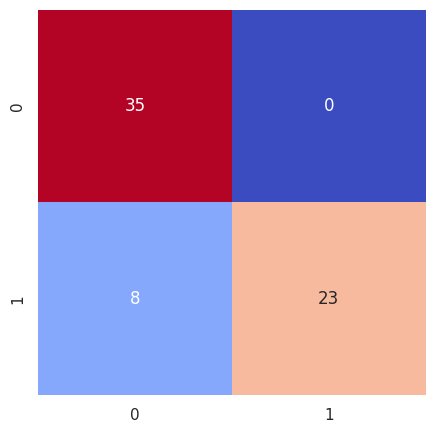

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc = metrics.accuracy_score(testY,preds)
acc

0.8787878787878788

In [ ]:
indexes = np.random.randint(0,30,25)
indexes

array([ 2,  3, 25, 24,  8, 19, 29, 27, 10, 24,  1, 28, 26, 21, 22, 28, 23,
        9, 16, 22,  2, 22, 12,  0, 17])

In [ ]:
labels = []

for i in indexes:
  pred = le.inverse_transform(preds)[i]
  labels.append(pred)

In [ ]:
labels

['healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy']

In [ ]:
results = []

for i in range(25):
  image = outputs[i]

  if labels[i] == 'healthy':
    color = (0,255,0)
  else:
    color = (0,0,255)

  text = str(labels[i])

  image = cv2.resize(image,(128,128))
  cv2.putText(image,text,(3,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

  results.append(image)


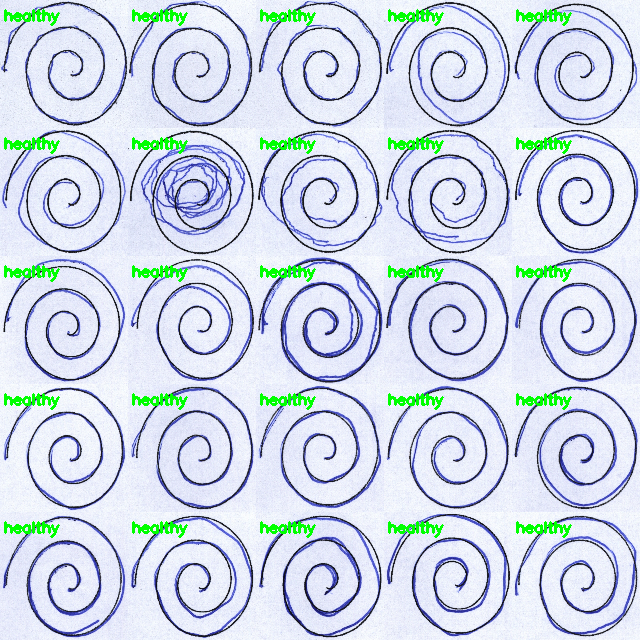

-1

In [ ]:
montage = build_montages(results,(128,128),(5,5))[0]

cv2_imshow(montage)
cv2.waitKey(0)

#Decision Trees

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=7)
clf.fit(trainX,trainY)

DecisionTreeClassifier(max_depth=7)

In [ ]:
preds_dt = clf.predict(testX)
preds_dt

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds_dt)
cnf

array([[29,  6],
       [10, 21]])

In [ ]:
sensitivity=29/(29+10)
sensitivity

0.7435897435897436

In [ ]:
specificity=21/(21+6)
specificity

0.7777777777777778

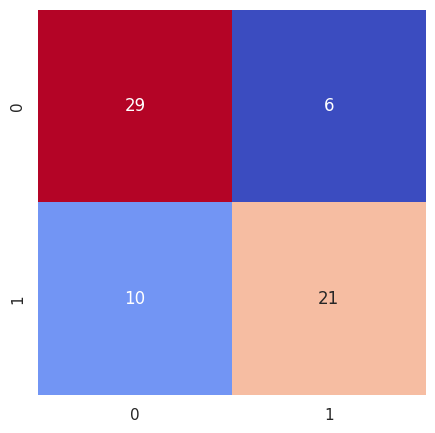

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_dt = metrics.accuracy_score(testY,preds_dt)
acc_dt

0.7575757575757576

#Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svm_mod = SVC(probability=True)
svm_mod.fit(trainX,trainY)

SVC(probability=True)

In [ ]:
pred_svc = svm_mod.predict(testX)
pred_svc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,pred_svc)
cnf

array([[33,  2],
       [ 4, 27]])

In [ ]:
sensitivity= 33/(33+4)
sensitivity

0.8918918918918919

In [ ]:
specificity=27/(27+2)
specificity

0.9310344827586207

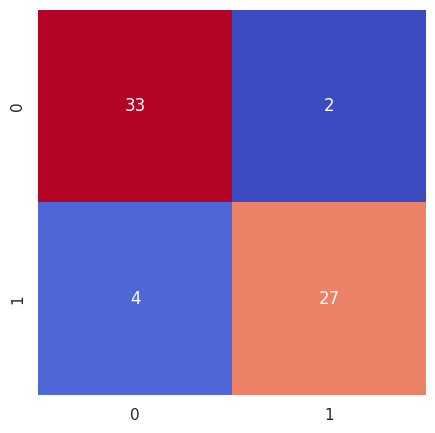

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_svc = metrics.accuracy_score(testY,pred_svc)
acc_svc

0.9090909090909091

In [ ]:
with open('/content/drive/MyDrive/spiral_svm_model_pkl.pkl', 'wb') as files:
    pickle.dump(svm_mod, files)

# Logistic Regression

In [ ]:
lg_mod = LogisticRegression()
lg_mod.fit(trainX, trainY)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
pred_lg = lg_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_lg)
cnf

array([[34,  1],
       [ 6, 25]])

In [ ]:
sensitivity=34/(34+6)
sensitivity

0.85

In [ ]:
specificity=25/(25+1)
specificity

0.9615384615384616

In [ ]:
acc_lg = metrics.accuracy_score(testY,pred_lg)
acc_lg

0.8939393939393939

# Naive Bayes

In [ ]:
gnb_mod = GaussianNB()
gnb_mod.fit(trainX, trainY)

GaussianNB()

In [ ]:
pred_nb = gnb_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_nb)
cnf

array([[29,  6],
       [15, 16]])

In [ ]:
sensitivity=29/(29+15)
sensitivity

0.6590909090909091

In [ ]:
specificity=16/(16+6)
specificity

0.7272727272727273

In [ ]:
acc_nb = metrics.accuracy_score(testY,pred_nb)
acc_nb

0.6818181818181818

No Skill AUC:  0.5
DecisionTree AUC:  0.752995391705069
Support Vector Machine AUC:  0.9548387096774192
Logistic Regression AUC:  0.9769585253456221
Gaussian Naive Bayes AUC:  0.6723502304147465


Text(0.5, 1.0, 'ROC curve')

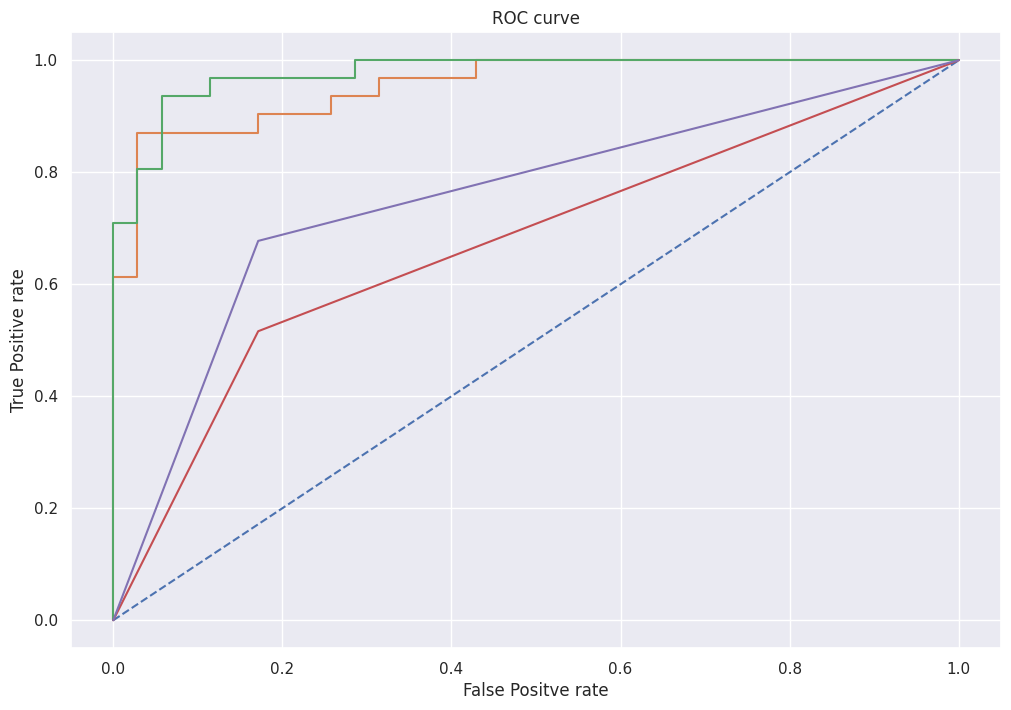

In [ ]:
no_skill_prob = [0 for _ in range(len(testY))]
no_skill_auc = roc_auc_score(testY, no_skill_prob)
print("No Skill AUC: ", no_skill_auc)
ns_fpr, ns_tpr, _ = roc_curve(testY, no_skill_prob)

dt_prob = clf.predict_proba(testX)[:,-1]
dt_auc = roc_auc_score(testY,dt_prob)
print("DecisionTree AUC: ", dt_auc)
dt_fpr, dt_tpr, _ = roc_curve(testY, dt_prob)

svm_prob = svm_mod.predict_proba(testX)[:,-1]
svm_auc = roc_auc_score(testY,svm_prob)
print("Support Vector Machine AUC: ", svm_auc)
svm_fpr, svm_tpr, _ = roc_curve(testY, svm_prob)

lg_prob = lg_mod.predict_proba(testX)[:,-1]
lg_auc = roc_auc_score(testY, lg_prob)
print("Logistic Regression AUC: ",lg_auc)
lg_fpr, lg_tpr, _ = roc_curve(testY, lg_prob)

nb_prob = gnb_mod.predict_proba(testX)[:,-1]
nb_auc = roc_auc_score(testY, nb_prob)
print("Gaussian Naive Bayes AUC: ", nb_auc)
nb_fpr, nb_tpr, _ = roc_curve(testY, nb_prob)


fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
ax.plot(dt_fpr, dt_tpr, linestyle='-', label= 'Decision Tree')

plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')


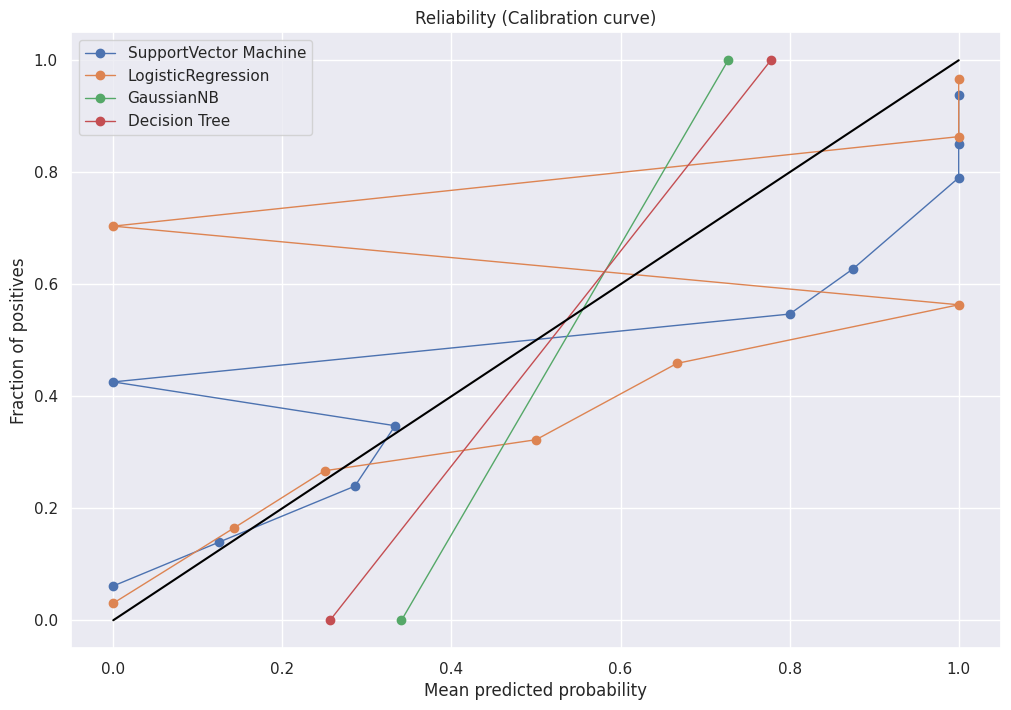

In [ ]:
sv_x, sv_y = calibration_curve(testY, svm_prob, n_bins=10)
lg_x, lg_y = calibration_curve(testY, lg_prob, n_bins=10)
nb_x, nb_y = calibration_curve(testY, nb_prob, n_bins=10)
dt_x, dt_y = calibration_curve(testY,dt_prob,n_bins=10)




fig, ax = plt.subplots(figsize=(12,8))

ax.plot(sv_x, sv_y, marker= 'o', linewidth= '1', label= 'SupportVector Machine')
ax.plot(lg_x, lg_y, marker= 'o', linewidth= '1', label= 'LogisticRegression')
ax.plot(nb_x, nb_y, marker= 'o', linewidth= '1', label= 'GaussianNB')
ax.plot(dt_x, dt_y, marker= 'o', linewidth= '1', label= 'Decision Tree')




line = mlines.Line2D([0,1],[0,1], color='black')
ax.add_line(line)
ax.legend()
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability (Calibration curve)')
plt.show()

In [ ]:
spiral_model = {
    'Random Forest': model,
    'Support Vector Machine': svm_mod,
    'Decision tree':clf,
    'Gaussian Naive Bayes': gnb_mod,
    'Logistic Regression': lg_mod

}

columns = [
    'accuracy'
]

spiral_table = {}


for model in spiral_model.keys():

    spiral_pred = spiral_model[model].predict(testX)
    accuracy = spiral_model[model].score(testX,testY)
    spiral_table[model] = [accuracy]

In [ ]:
spiral_results = pd.DataFrame.from_dict(spiral_table, orient='index')
spiral_results.columns = columns
spiral_results

accuracy
Random Forest           0.878788
Support Vector Machine  0.909091
Decision tree           0.757576
Gaussian Naive Bayes    0.681818
Logistic Regression     0.893939